<div align="center"><h1><b>Author:</b> Steven Gonder</h1></div>
<div>    
    <h3><b>Explanation:</b> This challenge requires parsing nested JSON data pulled from a PostgreSQL database in order to visualize user heart rate data and anxiety over time.</h3>    
</div>
<br/><br/>
<div><p><b>Data Challenges:</b> On initial inspection, I noticed a large portion of entries in the JSON file were duplicates, meaning that they had to be ignored in order to have performant lookups. The nested JSON format is a finicky data structure and the given the quantity of entries, I aimed to utilize data structures with fast lookups and non-repeating structure. The set data structure came to mind, although I realized I could pair the Unix timestamp key with the corresponding "data" field from the JSON payload. This led me to ultimately using a dictionary as my primary data structure.</p></div>
<br/>
<div><p><b>Next Steps:</b> Some rudimentary data validation was done but not currently enough for a production environment. I would do extensive testing if this were ever used in a production environment. I would also add more convenient graph zoom-in functionality for the user.</p></div>


In [140]:
import pandas as pd  # pandas is an "open source data analysis and manipulation tool"
import json
import datetime      # useful for translating between Unix time and UTC datetime
import matplotlib

In [141]:
%matplotlib inline

In [142]:
# open the json file
with open('awake_labs_smartwatch_data/awake_labs_smartwatch_data.json','r') as file:   
    json_obj = pd.read_json(file)

In [143]:
# there is one key in this data structure, and it's the SQL query
# for .. in .. syntax is used to iterate through keys in Python 3
for entry in json_obj:
    key = entry

In [144]:
# Since there are repeated entries in the JSON data, we use the timestamp as a hash table key, providing O(1) lookup
unique_entries={}

# the json key returns a value, which is a list
for i in json_obj[key]:
    # parse and iterate over list entries, grabbing the relevant portion: the 'data' JSON
    payload = json.loads(i['data'])
    # grab the timestamp to use as a unique key 
    timestamp = payload['time']
    # iff we haven't seen the key before, add it to our unique_entries dict
    if timestamp not in unique_entries:       
        # heartRates is the relevant nested JSON we wish to extract
        unique_entries[timestamp] = payload['heartRates']

In [145]:
# the dict keys are unsorted, so we sort them to make selecting intervals faster
one_minute_increments = sorted(unique_entries)

In [146]:
# custom tick labels
hms   = '%H:%M:%S'        # format: 09:53:12
ip    = '%#I %p'          # format: 4 PM
bd    = '%b %#d'          # format: Dec 25
bd_ip = '%b %#d, %#I %p'  # format: Jan 21, 5 PM
by    = '%b %Y'           # format: Mar 2021

<div align="center"><h2>You can create an interval to visualize the heartRate data over time</h2></div>

In [147]:
# ***** USER INPUT BEGIN *****

# dataset goes from 2021-04-20 10:00:00 to 2021-05-13 03:59:59

# GMT timezone

# replace the dates below in the ' ' with your own
from_date = '2021-04-21 15:30:00'  
to_date =   '2021-04-21 17:30:00'

# set how many hours between each graph tick, minimum of 1
x_axis_tick_intervals = 1

# set the tick label type
tick_label = ip

# ***** USER INPUT END *****

In [148]:
# convert user string to datetime object
date_range = pd.to_datetime([from_date, to_date])

# calculate unix time from datetime
unix_time = (date_range - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# since the resulting Int64Index is basically a list
start = unix_time[0]*1000 
end   = unix_time[1]*1000 # multiply by 1000 to convert from seconds to milliseconds

# since each data list item is stamped at the end of its one minute worth of data collection
# we look for a stamp at minimum one minute greater than its given Unix time stamp
start += 60000 
end   += 60000 # 60 seconds * 1000 milliseconds

In [149]:
# filter out time stamps that satisfy the given range - this can be sped up with a binary search
time_frame = [time for time in one_minute_increments if time >= start and time <= end]

In [150]:
# iterate through the relevant keys in the interval, and retrieve the corresponding heartRates JSON 
accum = []
for i in range(len(time_frame)):
    key = time_frame[i]
    accum += unique_entries[key]

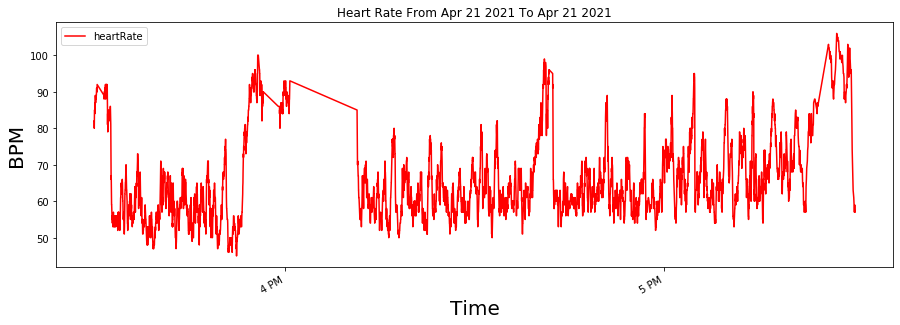

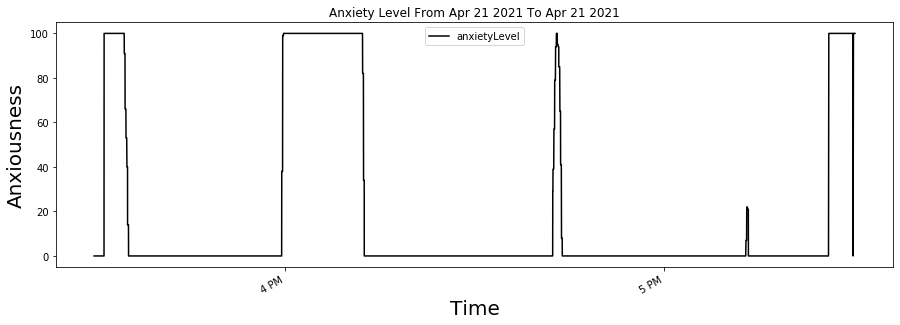

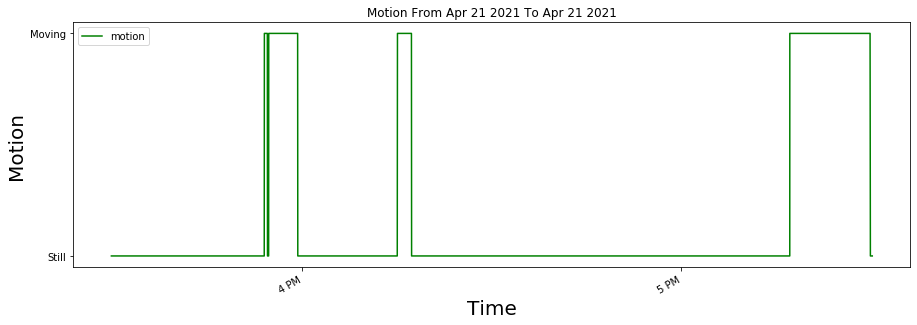

In [151]:
# convert accum to tabular form
snapshots = pd.json_normalize(accum)

# prevent the app from crashing if no data, and inform the user of the issue
if 'time' not in snapshots:
   print("No data available over this time frame")
else:
    # put time in a datetime format
    snapshots['time'] = pd.to_datetime(snapshots['time'], unit='ms')    
    snapshots['motion'] = snapshots['motion'].astype(int)

    # create the graph for heart rate
    pl = snapshots.plot(x="time", y="heartRate", figsize=(15,5), color="red")

    # create a second graph for anxiety level
    pl2 = snapshots.plot(x="time", y="anxietyLevel", figsize=(15,5), color="black")
    
    # create a third graph for whether or not the wearer is moving
    pl3 = snapshots.plot(x="time", y="motion", figsize=(15,5), color="green")

    # set basic plot properties
    pl.set_title('Heart Rate From ' + pd.Timestamp(from_date).strftime('%b %#d %Y') + \
                           ' To '   + pd.Timestamp(to_date).strftime('%b %#d %Y'))
    pl.set_ylabel("BPM", fontsize=20)
    pl.set_xlabel("Time", fontsize=20)

    pl2.set_title('Anxiety Level From ' + pd.Timestamp(from_date).strftime('%b %#d %Y') + \
                               ' To '   + pd.Timestamp(to_date).strftime('%b %#d %Y'))
    pl2.set_xlabel("Time", fontsize=20)
    pl2.set_ylabel("Anxiousness", fontsize=20)
    
    pl3.set_title('Motion From ' + pd.Timestamp(from_date).strftime('%b %#d %Y') + \
                           ' To '   + pd.Timestamp(to_date).strftime('%b %#d %Y'))
    pl3.set_ylabel("Motion", fontsize=20)
    pl3.set_xlabel("Time", fontsize=20)
    # set labels for Motion graph y-axis
    matplotlib.pyplot.yticks([1, 0], ["Moving", "Still"])

    # override default Pandas x-axis formatting 
    pl.x_compat=True
    pl2.x_compat=True
    pl3.x_compat=True

    # set the intervals for the graph ticks and their human-readable labels
    intervals = matplotlib.dates.HourLocator(interval = x_axis_tick_intervals)
    label_format = matplotlib.dates.DateFormatter(tick_label)
    pl.xaxis.set_major_locator(intervals)
    pl.xaxis.set_major_formatter(label_format)
    pl2.xaxis.set_major_locator(intervals)
    pl2.xaxis.set_major_formatter(label_format)
    pl3.xaxis.set_major_locator(intervals)
    pl3.xaxis.set_major_formatter(label_format)

<p><b>Insight:</b> Here we can see the smartwatch wearer had an increasing heart rate at around 3:30 PM, 3:50 PM, 4:40 PM, and 5:40 PM, and these spikes in BPM were almost immediately followed by massive spikes in personal anxiety. With the possible exception of the data gap from 4:00 PM to 4:15 PM (signified by a straight slope), these periods of intense anxiousness lasted approximately 10 minutes with a peak heart rate of between 90 and 105 BPM. The increased heart rate and anxiety corresponded with the wearer moving around at 3:50 PM and 5:40 PM, but not for 3:30 PM and 4:40 PM. The two latter cases may be more concerning therefore.</p>
<br/>    
<p>With this body of knowledge, the wearer's caretaker could potentially discover what stressers triggered these events throughout the afternoon of April 21st and look into ways to mitigate them going forward.</p>      